### 1번

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   VendorName  209 non-null    object
 1   ModelName   209 non-null    object
 2   MYCT        209 non-null    int64 
 3   MMIN        209 non-null    int64 
 4   MMAX        209 non-null    int64 
 5   CACH        209 non-null    int64 
 6   CHMIN       209 non-null    int64 
 7   CHMAX       209 non-null    int64 
 8   PRP         209 non-null    int64 
 9   ERP         209 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 16.5+ KB
PRP                    1.000000
ERP                    0.966472
MMAX                   0.863004
MMIN                   0.794931
CACH                   0.662641
                         ...   
mname_v8655            0.002430
mname_as/6650          0.002324
mname_50-850-ii        0.001460
mname_as/7000-n        0.000269
mname_cyber:170/835    0.000163
Name: PRP, L

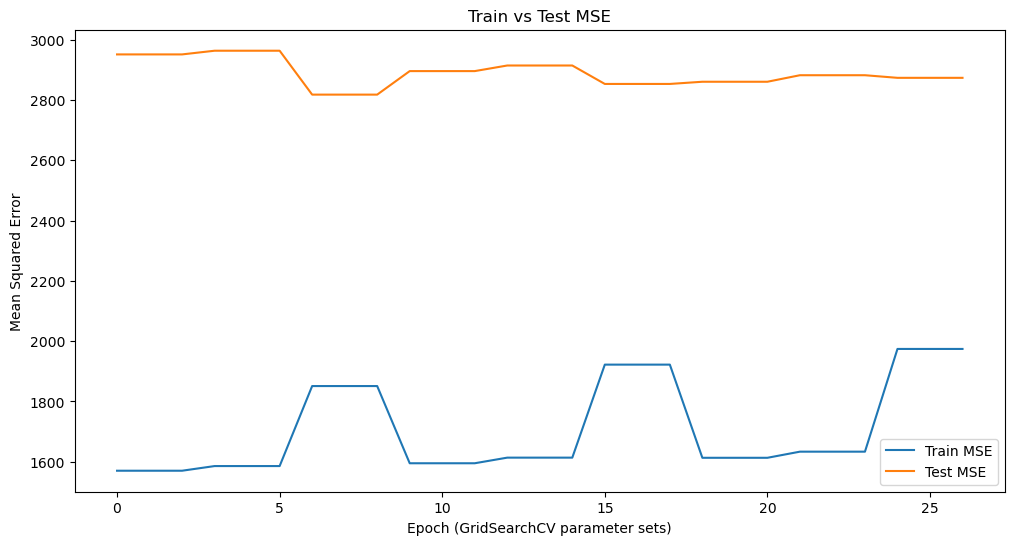

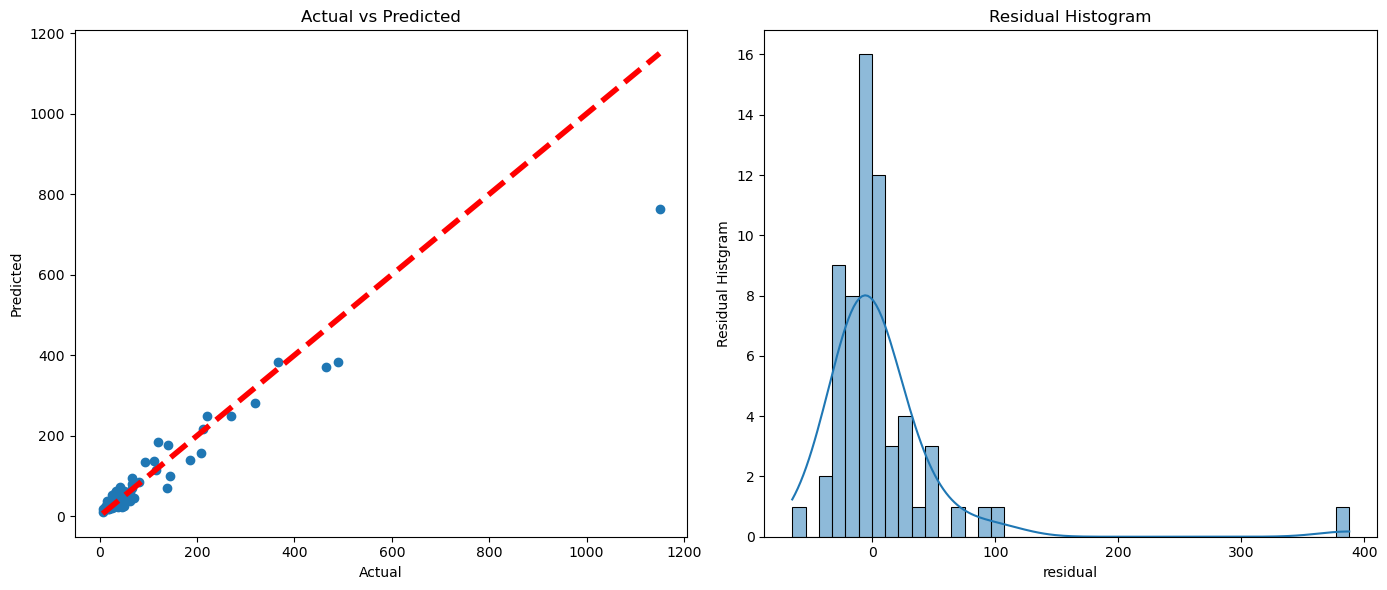

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.ensemble import VotingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

modelset=pd.read_csv("machine.data_update.csv")
modelset.info()
modelset.dropna(inplace = True)

dum=pd.get_dummies(modelset.VendorName,prefix='vname',dtype=float)
modelset=pd.concat([modelset.drop("VendorName",axis=1),dum],axis=1)

dum=pd.get_dummies(modelset["ModelName"],prefix='mname',dtype=float)
modelset=pd.concat([modelset.drop("ModelName",axis=1),dum],axis=1)
modelset.head()

rela=modelset.corr()["PRP"]
rela=np.abs(rela)
print(rela.sort_values(ascending=False))


num_feat=['MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX','ERP']

y = modelset["PRP"]
X = modelset[num_feat]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 10)

num_transformer=Pipeline(steps=[('scaler',StandardScaler()),])
preprocessor=ColumnTransformer(transformers=[('num',num_transformer,num_feat),])

models=[('lr',LinearRegression()),
       ('sgd',SGDRegressor(random_state=42)),
       ('ridge',Ridge(random_state=42))]

ensemble=VotingRegressor(estimators=models)
model_pipe=Pipeline(steps=[('pre',preprocessor),('ensemble',ensemble)])

para_ense={'ensemble__sgd__alpha':[0.0001,0.01,1.0],
          'ensemble__sgd__max_iter':[1000,2000,3000],
          'ensemble__ridge__alpha':[10,20,30]}
grid_se=GridSearchCV(model_pipe,para_ense,cv=5,scoring="neg_mean_squared_error",return_train_score=True)
grid_se.fit(X_train,y_train)
best_mo=grid_se.best_estimator_

cv_score=cross_val_score(best_mo,X_train,y_train,cv=5,scoring="neg_mean_squared_error")
cv_mse=-cv_score.mean()
print(f"교차검증 mse:{cv_mse}")

y_pred = best_mo.predict(X_test)

results = pd.DataFrame(grid_se.cv_results_)

# 에폭을 X축으로, 훈련 점수 및 테스트 점수 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(len(results['mean_train_score'])), -results['mean_train_score'], label='Train MSE')
plt.plot(range(len(results['mean_test_score'])), -results['mean_test_score'], label='Test MSE')
plt.xlabel('Epoch (GridSearchCV parameter sets)')
plt.ylabel('Mean Squared Error')
plt.title('Train vs Test MSE')
plt.legend()
plt.show()


plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(y_test,y_pred)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],'r--',lw=4)
plt.xlabel('Actual')
plt.ylabel("Predicted")
plt.title('Actual vs Predicted')

plt.subplot(1,2,2)
sns.histplot(y_test - y_pred, kde=True)
plt.xlabel('residual')
plt.ylabel('Residual Histgram')
plt.title('Residual Histogram')
plt.tight_layout()
plt.show()



### 2번

In [14]:
cvmse=cross_val_score(best_mo,X_train,y_train,cv=5,scoring="neg_mean_squared_error")
cvmse=-cvmse.mean()

cvmae=cross_val_score(best_mo,X_train,y_train,cv=5,scoring="neg_mean_absolute_error")
cvmae=-cvmae.mean()

cvr2=cross_val_score(best_mo,X_train,y_train,cv=5,scoring="r2")
cvr2=cvr2.mean()
print(f"교차검증 결과- mse:{cvmse},mae:{cvmae},r2:{cvr2}")

y_train_pred=best_mo.predict(X_train)
mse_train=mean_squared_error(y_train,y_train_pred)
mae_train=mean_absolute_error(y_train,y_train_pred)
r2_train=r2_score(y_train,y_train_pred)

print(f"train-mse:{mse_train},mae:{mae_train},r2:{r2_train}")

mse_test=mean_squared_error(y_test,y_pred)
mae_test=mean_absolute_error(y_test,y_pred)
r2_test=r2_score(y_test,y_pred)

print(f"test-mse:{mse_test},mae:{mae_test},r2:{r2_test}")

교차검증 결과- mse:2817.4696470383424,mae:29.4597739156038,r2:0.7037795141262023
train-mse:1974.6323542729729,mae:26.334692842248522,r2:0.9193955830184029
test-mse:3220.40777052531,mae:25.844552350165678,r2:0.8873513344554874


### 3번

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   VendorName  209 non-null    object
 1   ModelName   209 non-null    object
 2   MYCT        209 non-null    int64 
 3   MMIN        209 non-null    int64 
 4   MMAX        209 non-null    int64 
 5   CACH        209 non-null    int64 
 6   CHMIN       209 non-null    int64 
 7   CHMAX       209 non-null    int64 
 8   PRP         209 non-null    int64 
 9   ERP         209 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 16.5+ KB
None
              MYCT          MMIN          MMAX        CACH       CHMIN  \
count   209.000000    209.000000    209.000000  209.000000  209.000000   
mean    203.822967   2867.980861  11796.153110   25.205742    4.698565   
std     260.262926   3878.742758  11726.564377   40.628722    6.816274   
min      17.000000     64.000000     64.000000    0.000000    0

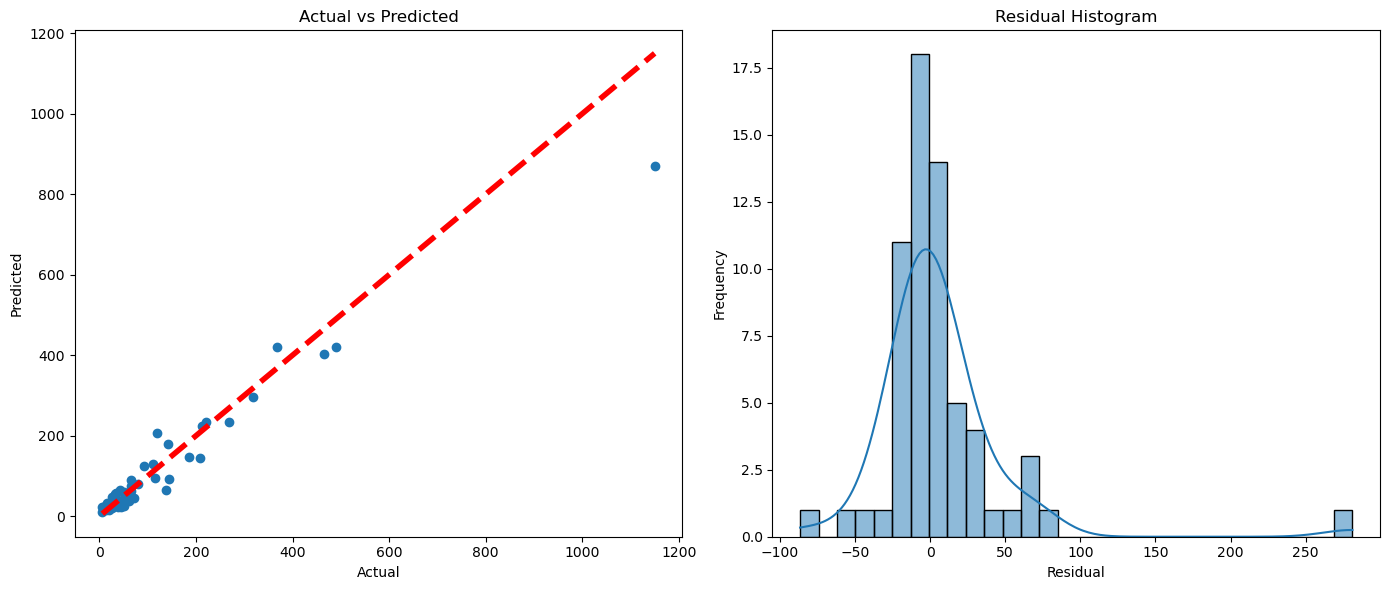

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 데이터 불러오기
modelset = pd.read_csv("machine.data_update.csv")
modelset.dropna(inplace=True)

# Explore the dataset
print(modelset.info())
print(modelset.describe())
print(modelset.head())




# 특징 선택
num_feat = ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX','ERP']

# 특징들 x,y 선별
y = modelset["PRP"]
X = modelset[num_feat]

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

# 전처리부
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])


preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_feat)
])

# 모델들 정의
models = [
    ('lr', LinearRegression()),
    ('sgd', SGDRegressor(random_state=42)),
    ('ridge', Ridge(random_state=42)),
    ('gbr',GradientBoostingRegressor(random_state=42))
]

# 앙상블 생성
ensemble = VotingRegressor(estimators=models)

# 파이프 라인으로 연결
model_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ensemble', ensemble)
])
param_grid={ 
    #정규화 정도를 조정,전자는 반복횟수
    'ensemble__sgd__max_iter':[1000,2000],'ensemble__sgd__alpha':[0.001,0.01],
    'ensemble__ridge__alpha':[10,20],'ensemble__gbr__n_estimators':[100,200],  'ensemble__gbr__learning_rate':[0.01,0.1]            #처리할 값을 뒤에 리스트에 담는다.
}
# GridSearchCV 설정 및 모델 학습 5계단계 거쳐 어떤 평가지표 사용할지 지정.
grid_search = GridSearchCV(model_pipe,param_grid,cv=5,scoring='neg_mean_squared_error',return_train_score=True) #파이프라인,파라미터,교차검증사용
#grid_search_mae = Gri_dSearchCV(model_pipeline,param_grid,cv=5,scoring='neg_mean_absolute_error',return_train_score=True) #파이프라인,파라미터,교차검증사용

grid_search.fit(X_train,y_train)
best_model=grid_search.best_estimator_

#검증
y_pred = best_model.predict(X_test)
y_train_pred = best_model.predict(X_train)

mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print(f"Train MSE: {mse_train:.4f}")
print(f"Train MAE: {mae_train:.4f}")
print(f"Train R^2: {r2_train:.4f}")

mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print(f"Test MSE: {mse_test:.4f}")
print(f"Test MAE: {mae_test:.4f}")
print(f"Test R^2: {r2_test:.4f}")

# Plot Actual vs Predicted values
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')

# Plot residuals
plt.subplot(1,2,2)
sns.histplot(y_test - y_pred, kde=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')
plt.tight_layout()
plt.show()


### 4번

Cross-Validation R^2 scores: [0.5912341  0.57331442 0.74333143 0.78087197 0.91611619]
Mean CV R^2 score: 0.7209736232334645
Train R^2: 0.8902
Train MSE: 2003.7386
Train MAE: 26.3952
test-mse:4012.784737076277,mae:39.019149216493894,r2:0.9233626956154231


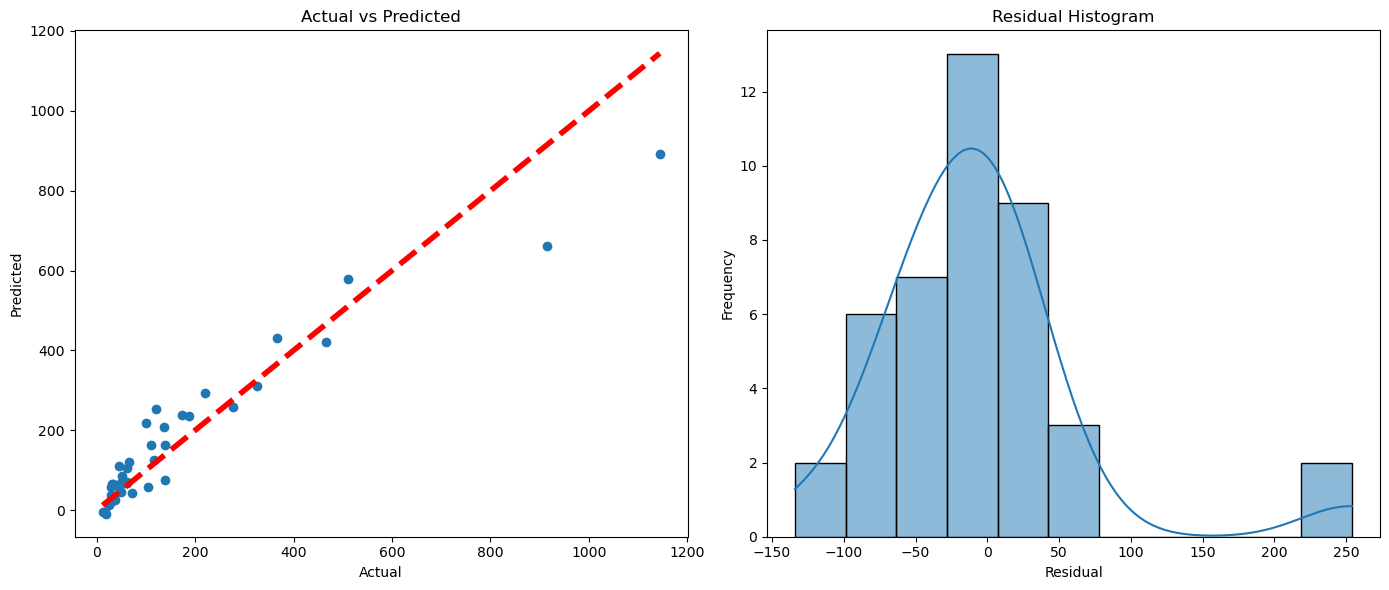

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 데이터 로드
modelset = pd.read_csv("machine_data.csv")
modelset.dropna(inplace=True)

# 수치형 특징 정의
num_feat = ['MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX','MYCT']

# 타겟 변수 정의
y = modelset["PRP"]
X = modelset[num_feat]

# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# 수치형 데이터 전처리 파이프라인 생성
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# 전처리 결합
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_feat)
])

# 앙상블에 사용할 모델 정의
models = [
    ('lr', LinearRegression()),
    ('sgd', SGDRegressor(random_state=42, alpha=0.01, max_iter=2000)),
    ('ridge', Ridge(random_state=42, alpha=20)),
    ('gbr', GradientBoostingRegressor(random_state=42))
]

# 앙상블 회귀 모델 생성
ensemble = VotingRegressor(estimators=models)

model_pipe=Pipeline(steps=[('pre',preprocessor),('ensemble',ensemble)])
para_ense = {
    'ensemble__sgd__alpha': [0.001, 0.01],
    'ensemble__sgd__max_iter': [1000, 2000],
    'ensemble__ridge__alpha': [10, 20],
    'ensemble__gbr__n_estimators': [100, 200],
    'ensemble__gbr__learning_rate': [0.01, 0.1]
}
grid_se=GridSearchCV(model_pipe,para_ense,cv=5,scoring="neg_mean_squared_error",return_train_score=True)
grid_se.fit(X_train,y_train)
best_mo=grid_se.best_estimator_

# 파이프라인 생성
y_pred = best_mo.predict(X_test)
# 모델 훈련
model_pipe.fit(X_train, y_train)

# 교차 검증을 통한 모델 평가
cv_scores = cross_val_score(model_pipe, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-Validation R^2 scores: {cv_scores}")
print(f"Mean CV R^2 score: {cv_scores.mean()}")

# 훈련 데이터에 대해 예측
y_train_pred = model_pipe.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)

print(f"Train R^2: {r2_train:.4f}")
print(f"Train MSE: {mse_train:.4f}")
print(f"Train MAE: {mae_train:.4f}")

# 테스트 데이터에 대해 예측
mse_test=mean_squared_error(y_test,y_pred)
mae_test=mean_absolute_error(y_test,y_pred)
r2_test=r2_score(y_test,y_pred)

print(f"test-mse:{mse_test},mae:{mae_test},r2:{r2_test}")
# 시각화
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')

plt.subplot(1, 2, 2)
sns.histplot(y_test - y_test_pred, kde=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')
plt.tight_layout()
plt.show()


### 4번

               Model              Data          MSE        MAE       R^2
0  Linear Regression             Train  1641.531000  24.442695  0.932993
1  Linear Regression              Test  1850.745114  23.545205  0.935262
2  Linear Regression  Cross Validation  3171.781469  30.708239  0.700036
3     Best_estimator             Train  1974.632354  26.334693  0.919396
4     Best_estimator              Test  3220.407771  25.844552  0.887351
5     Best_estimator  Cross Validation  2817.469647  29.459774  0.703780


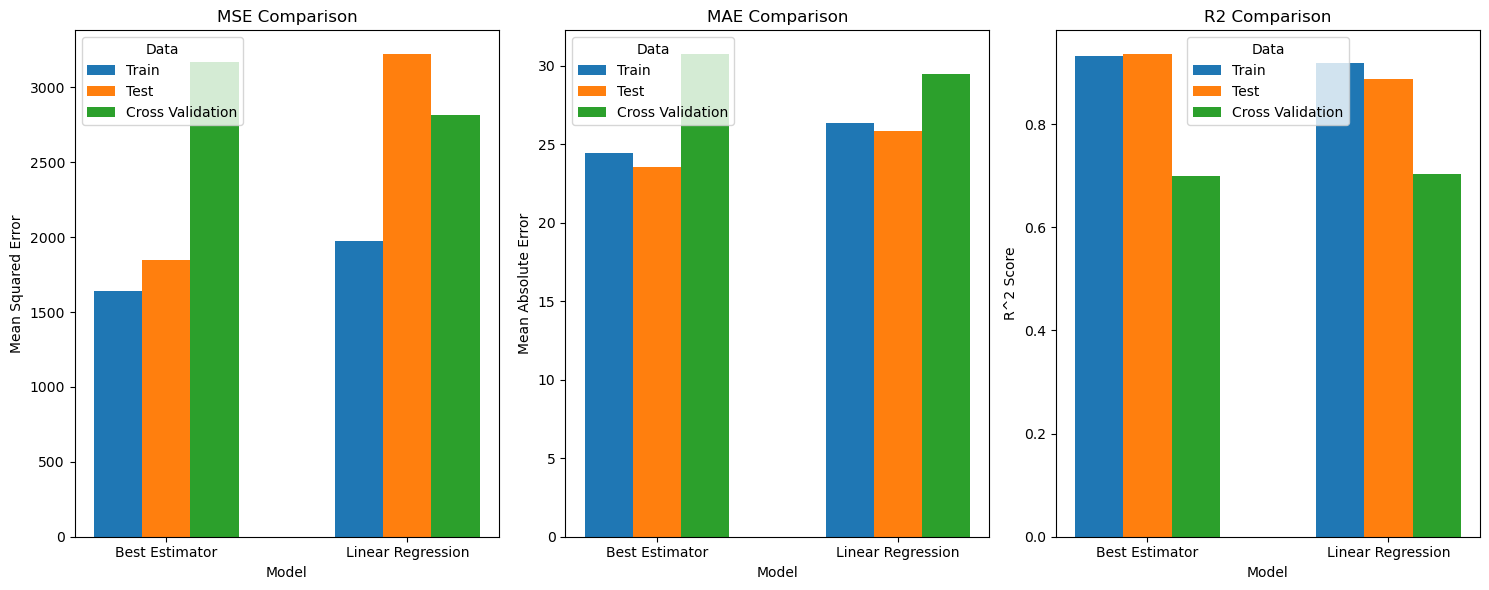

In [109]:
df=pd.read_csv('model_result.csv')
new_data={'Model':['Best_estimator','Best_estimator','Best_estimator'],
          'Data':['Train','Test','Cross Validation'],
                 'MSE':[mse_train,mse_test,cvmse],
          'MAE':[mae_train,mae_test,cvmae],
                'R^2':[r2_train,r2_test,cvr2]}
df2=pd.DataFrame(new_data)
df=pd.concat([df,df2],ignore_index=True)
print(df)
MSE=df['MSE'].values.tolist()
MAE=df['MAE'].values.tolist()
R2=df['R^2'].values.tolist()

Test_mse=[MSE[1],MSE[4]]
Train_mse=[MSE[0],MSE[3]]
cv_mse=[MSE[2],MSE[5]]

Test_mae=[MAE[1],MAE[4]]
Train_mae=[MAE[0],MAE[3]]
cv_mae=[MAE[2],MAE[5]]

Test_r2=[R2[1],R2[4]]
Train_r2=[R2[0],R2[3]]
cv_r2=[R2[2],R2[5]]

all={'train_ms':Train_mse,
     'test_ms':Test_mse,
     'cv_ms':cv_mse,
     'train_ma':Train_mae,
     'test_ma':Test_mae,
     'cv_ma':cv_mae,
     'train_r2':Train_r2,
     'test_r2':Test_r2,
     'cv_r2':cv_r2,   
}

new_df=pd.DataFrame(all)

index=np.arange(2)

# # 그림 사이즈 설정
_, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
axs[0].bar(index-0.2,new_df['train_ms'],width=0.2,label='Train')
axs[0].bar(index,new_df['test_ms'],width=0.2,label='Test')
axs[0].bar(index+0.2,new_df['cv_ms'],width=0.2,label='Cross Validation')
axs[0].set_xticks(index)
axs[0].set_xticklabels(['Best Estimator', 'Linear Regression'])
axs[0].set_title('MSE Comparison')
axs[0].legend(title='Data')
axs[0].set_xlabel('Model')
axs[0].set_ylabel('Mean Squared Error')

axs[1].bar(index-0.2,new_df['train_ma'],width=0.2,label='Train')
axs[1].bar(index,new_df['test_ma'],width=0.2,label='Test')
axs[1].bar(index+0.2,new_df['cv_ma'],width=0.2,label='Cross Validation')
axs[1].set_xticks(index)
axs[1].set_xticklabels(['Best Estimator', 'Linear Regression'])
axs[1].set_title('MAE Comparison')
axs[1].set_xlabel('Model')
axs[1].set_ylabel('Mean Absolute Error')
axs[1].legend(title='Data')

axs[2].bar(index-0.2,new_df['train_r2'],width=0.2,label='Train')
axs[2].bar(index,new_df['test_r2'],width=0.2,label='Test')
axs[2].bar(index+0.2,new_df['cv_r2'],width=0.2,label='Cross Validation')
axs[2].set_xticks(index)
axs[2].set_xticklabels(['Best Estimator', 'Linear Regression'])
axs[2].set_title('R2 Comparison')
axs[2].set_xlabel('Model')
axs[2].set_ylabel('R^2 Score')
axs[2].legend(title='Data')


plt.xlabel('Model')
plt.tight_layout() #for밖에 써야됨,안그러면 매번 간격조정해 이상하게 나옴.
plt.show()

[0.4 1.4]
[0. 1.]
[0.2 1.2]
[0.4 1.4]


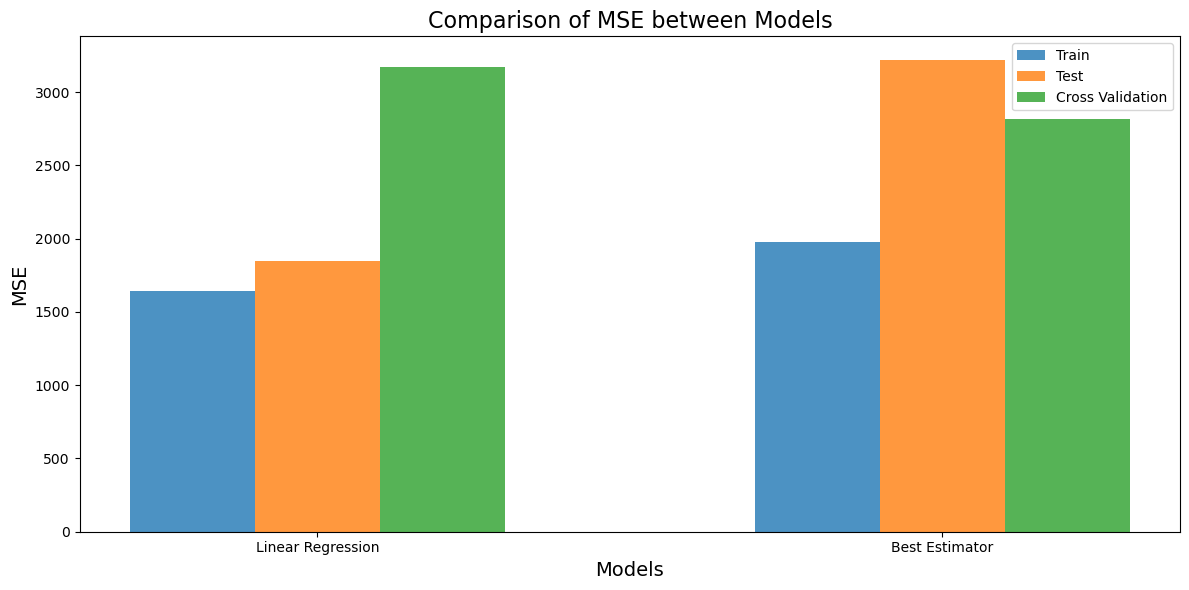

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# 주어진 데이터
models = ['Linear Regression', 'Best Estimator']
data_types = ['Train', 'Test', 'Cross Validation']
mse_values = {
    'Linear Regression': [1641.531000, 1850.745114, 3171.781469],
    'Best Estimator': [1974.632354, 3220.407771, 2817.469647]
}

# 그림 사이즈 설정
plt.figure(figsize=(12, 6))

# 막대 너비 설정
bar_width = 0.2

# 막대 그래프의 위치 설정
nrow=df.shape
print(nrow)
index = np.arange(len(models))
print(index + i * bar_width)

# Train, Test, Cross Validation에 대한 막대 그래프 그리기
for i, data_type in enumerate(data_types):
    print(index + i * bar_width)
    plt.bar(index + i * bar_width, [mse_values[model][i] for model in models], bar_width, alpha=0.8, label=data_type)

# x축 설정
plt.xlabel('Models', size=14)
plt.ylabel('MSE', size=14)
plt.title('Comparison of MSE between Models', size=16)
plt.xticks(index + bar_width, models)

# 범례 추가
plt.legend()

# 그래프 출력
plt.tight_layout()
plt.show()

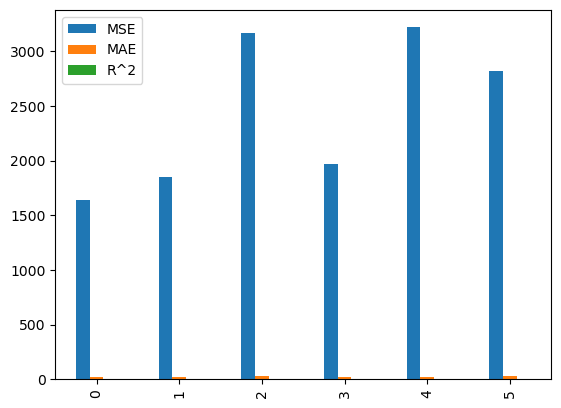

In [100]:
df.plot.bar()
plt.show()